In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from matplotlib import pyplot as plt

import pandas as pd
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [3]:
dataset_location = Path('/mnt') / "e" / "datasets" / "training.1600000.processed.noemoticon.csv"

In [4]:
# target: the polarity of the tweet (0 = negative, 2 = neutral, 4 = positive)
# ids: The id of the tweet ( 2087)
# date: the date of the tweet (Sat May 16 23:58:44 UTC 2009)
# flag: The query (lyx). If there is no query, then this value is NO_QUERY.
# user: the user that tweeted (robotickilldozr)
# text: the text of the tweet (Lyx is cool)
dataset = pd.read_csv(dataset_location, encoding='latin-1', header=None)
dataset.columns = ['target', 'ids', 'date', 'flag', 'user', 'text']

KeyboardInterrupt: 

# Analisis de datos

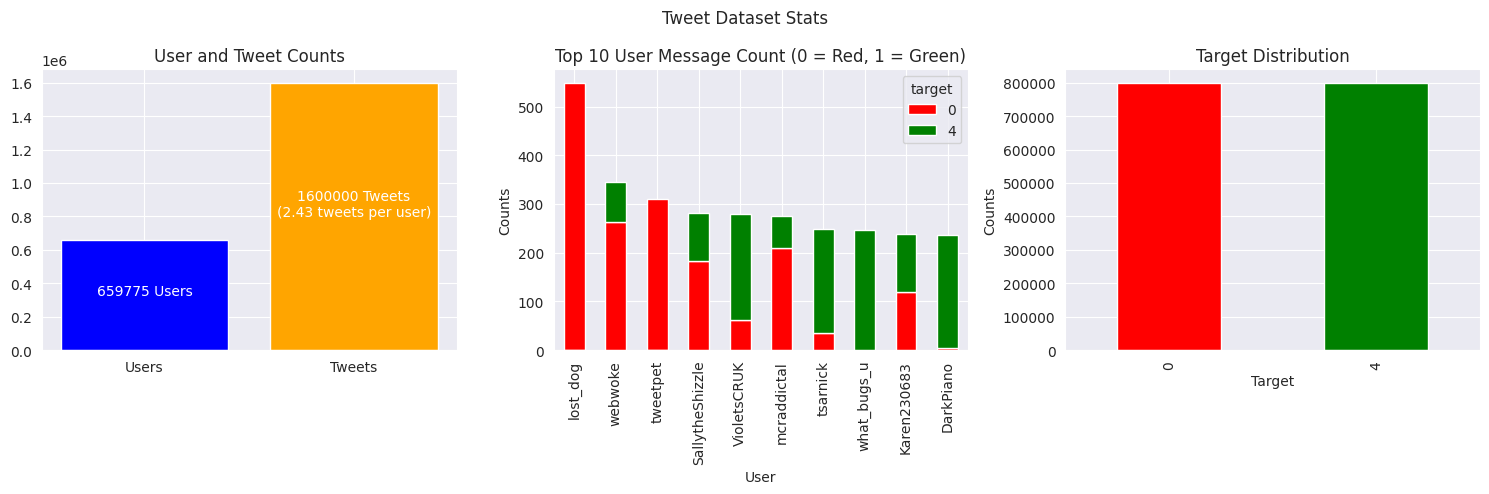

In [5]:
# Calculate user and tweet stats
user_count = len(dataset['user'].unique())
tweet_count = len(dataset['user'])
tweets_per_user = tweet_count / user_count

# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot 1: User count stats
axs[0].bar(['Users', 'Tweets'], [user_count, tweet_count], color=['blue', 'orange'])
axs[0].text(0, user_count / 2, f'{user_count} Users', ha='center', color='white')
axs[0].text(1, tweet_count / 2, f'{tweet_count} Tweets\n({tweets_per_user:.2f} tweets per user)', ha='center',
            color='white')
axs[0].set_title('User and Tweet Counts')

# Plot 2: Top 10 users stacked by target
top_users = dataset['user'].value_counts().nlargest(10).index
filtered_data = dataset[dataset['user'].isin(top_users)]
pivot_table = filtered_data.pivot_table(index='user', columns='target', aggfunc='size', fill_value=0)
pivot_table['total'] = pivot_table.sum(axis=1)
pivot_table = pivot_table.sort_values('total', ascending=False).drop('total', axis=1)
pivot_table.plot(kind='bar', stacked=True, color=['red', 'green'], ax=axs[1])
axs[1].set_title('Top 10 User Message Count (0 = Red, 1 = Green)')
axs[1].set_xlabel('User')
axs[1].set_ylabel('Counts')

# Plot 3: Target distribution
dataset['target'].value_counts().plot(kind='bar', color=['red', 'green'], ax=axs[2])
axs[2].set_title('Target Distribution')
axs[2].set_xlabel('Target')
axs[2].set_ylabel('Counts')

plt.suptitle('Tweet Dataset Stats')
# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [6]:
# Message length
dataset['message_length'] = dataset['text'].apply(len)

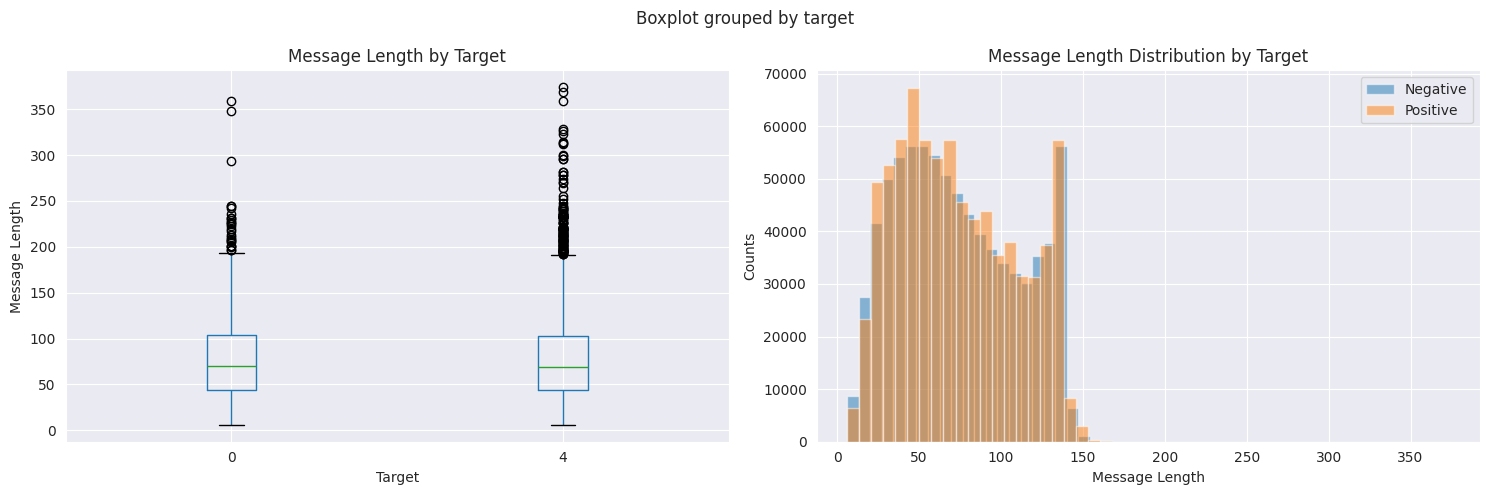

In [7]:

# Create figure and subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Boxplot of length by target
dataset.boxplot('message_length', by='target', ax=axs[0])
axs[0].set_title('Message Length by Target')
axs[0].set_xlabel('Target')
axs[0].set_ylabel('Message Length')
# Move x ticks closer together


# Plot 2: Message length distribution by target

dataset.groupby('target')['message_length'].plot(kind='hist', bins=50, alpha=0.5, ax=axs[1])
axs[1].legend(['Negative', 'Positive'])
axs[1].set_title('Message Length Distribution by Target')
axs[1].set_xlabel('Message Length')
axs[1].set_ylabel('Counts')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [8]:
dataset[dataset['message_length'] > 160]['text']

13538      Took niece &amp; nephew to Blockbuster- rented...
16809      @SongzYuuup wat is the name of ur mixtape with...
19818      I don't like it when people use the word &quot...
26880      @victoriax3jonas such as the &quot;we will do ...
29196      Maybe it's just me, but when someone tells me ...
                                 ...                        
1587593    Ð?Ð°Ñ?ÑÑÐ¾ÐµÐ½Ð¸ÐµÑÐ¾ Ð¼Ð¸ Ð´Ð½ÐµÑ? Ðµ Ð² Ð...
1590660    Look I was a Raver back in the Day and Still A...
1595705    @ravidreams orutharuku onnu pudikathunu therin...
1597559    @antiprism &quot;So Dan, u want JIRA for the d...
1598103    Finally! The Space Ð¡akes are on Twitter! Welc...
Name: text, Length: 476, dtype: object

# Preprocesamiento de datos

In [9]:
# Remove long messages
p_dataset = dataset
p_dataset = p_dataset[p_dataset['message_length'] <= 160]

In [10]:
# Remove user, date and flag columns

p_dataset = p_dataset.drop(['user', 'date', 'flag', 'ids', 'message_length'], axis=1)

# Split dataset

In [11]:
from sklearn.model_selection import train_test_split

train_data, test_eval_data = train_test_split(p_dataset, test_size=0.3, random_state=42, stratify=p_dataset['target'])
test_data, eval_data = train_test_split(test_eval_data, test_size=0.5, random_state=42,
                                        stratify=test_eval_data['target'])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)
eval_data.reset_index(drop=True, inplace=True)

In [12]:
print(f"Train data: {len(train_data)}, Test data: {len(test_data)}, Eval data: {len(eval_data)}")
train_data

Train data: 1119666, Test data: 239929, Eval data: 239929


,target,text
0,4,@letscall_l your welcome
1,4,@patientZeroBand build your own!
2,0,goin to bed
3,4,austin makes me reallll happy
4,4,going to a movie night.. jeppi!!
...,...,...
1119661,0,In town today and i see this.. http://www.twit...
1119662,4,church tomorrow then goin swiming
1119663,0,@crustydolphin so sorry honey x
1119664,4,"@arynet Thanks, will look into it."


In [13]:

import torch.utils.data.dataset


class TweetDataset(torch.utils.data.Dataset):
  def __init__(self, data, tokenizer, max_length):
    self.data = data
    self.tokenizer = tokenizer
    self.max_length = max_length

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    row = self.data.iloc[index]
    encoding = self.tokenizer(row['text'], max_length=self.max_length, truncation=True, padding='max_length',
                              return_tensors='pt')
    
    return {
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      # 'target': torch.tensor(row['target'])
      "text": row['text'],
      "labels": 0 if row['target'] == 0 else 1
    }




# Model

In [14]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer


In [15]:

# distilbert: DistilBertForSequenceClassification
distil_bert = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Dataset

train_ds = TweetDataset(train_data, tokenizer, 160)
test_ds = TweetDataset(test_data, tokenizer, 160)
eval_ds = TweetDataset(eval_data, tokenizer, 160)

In [17]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
  output_dir='./results',
  num_train_epochs=3,
  per_device_train_batch_size=8,
  per_device_eval_batch_size=8,
  warmup_steps=500,
  weight_decay=0.01,
  logging_dir='./logs',
  logging_steps=10,
  evaluation_strategy='steps',
  eval_steps=100,
  save_steps=100,
  save_total_limit=3,
  load_best_model_at_end=True,
  metric_for_best_model='eval_loss',
  greater_is_better=False,
  run_name='distilbert-base-uncased'
)

trainer = Trainer(
  model=distil_bert,
  args=training_args,
  tokenizer=tokenizer,
  train_dataset=train_ds,
  eval_dataset=eval_ds,
)

2024-10-09 22:53:55.322328: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-09 22:53:55.333192: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-09 22:53:55.336209: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-09 22:53:55.345067: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-09 22:53:56.595237: W tensorflow/compiler/tf2

In [18]:

trainer.train()

Step,Training Loss,Validation Loss
100,0.687800,0.679331
200,0.611700,0.547974
300,0.516300,0.505225
400,0.458300,0.497366
500,0.462600,0.494742
600,0.570700,0.525876
700,0.414700,0.488595
800,0.510300,0.508140
900,0.437000,0.480410
1000,0.532600,0.484484


KeyboardInterrupt: 

In [19]:
trainer.evaluate()

{'eval_loss': 0.41691911220550537}

In [20]:
distil_bert.save_pretrained('distilbert-base-uncased-sentiment')

In [5]:
from transformers import pipeline

classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-sentiment', tokenizer='distilbert-base-uncased', device=0)

2024-10-10 19:32:43.432065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:476] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1728599563.505755 2001395 cuda_dnn.cc:8312] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1728599563.534536 2001395 cuda_blas.cc:1420] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-10 19:32:43.704722: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
classifier('I love you')

[{'label': 'LABEL_1', 'score': 0.9455501437187195}]

In [26]:
classifier('I hate you')

[{'label': 'LABEL_0', 'score': 0.9829870462417603}]

In [62]:
classifier('Cat\'s are the most vile creature - that is why I like this movie - but I hate it\'s director - and I love i\'s actors - and the plot is great but it because it sucks at portraying dogs as heroes - it\'s even better')

[{'label': 'LABEL_0', 'score': 0.6930216550827026}]

In [6]:
def get_good_bad_string(base: str, length: int):
  if length == 0:
    return base
  clz = classifier(base)[0]['label'] == 'LABEL_1'
  return get_good_bad_string(f"{base} {'not good' if clz else 'good'}", length - 1)
get_good_bad_string('', 200)

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


' good not good good good good good good good good good good good good good good good good good good good good good good good good not good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good not good good good good good good good good good good good good good good good good good not good good good good good good good good good good good good good good good good good good good good good good good good good good not good good good good good good good good good good good good good good good good not good good good good good good good good good good good good good good good good good good good good good good good good good good good good good good not good good good good good good good good good good good good not good good good good good good good good good good good good good good not good good good good good good good good not good good good good good good good good good goo

In [38]:
from sklearn.metrics import f1_score, classification_report

In [44]:
test_predictions = classifier([row['text'] for row in test_data.to_dict(orient='records')][:10000])

In [45]:
test_labels = [0 if row['target'] == 0 else 1 for row in test_data.to_dict(orient='records')[:10000]]

In [46]:
mapped_predictions = [0 if prediction['label'] == 'LABEL_0' else 1 for prediction in test_predictions]

In [47]:
f1_score(test_labels, mapped_predictions)

0.8087690407575134

In [48]:
print(classification_report(test_labels, mapped_predictions))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      5094
           1       0.82      0.80      0.81      4906

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000

